In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import LongType
from pyspark.sql import Window
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create the hive database

In [0]:
%sql

DROP DATABASE IF EXISTS statcan CASCADE;
CREATE DATABASE IF NOT EXISTS statcan;
REFRESH TABLES

# Mount the blob storage

In [0]:
storage_account_name = dbutils.secrets.get(scope = 'key-secret-scope', key = 'blobstorageaccountname')
storage_account_key = dbutils.secrets.get(scope = 'key-secret-scope', key = 'blobstorageaccountkey')
container = 'rawdata'

Mound the blob storage such that data can be picked up from there

In [0]:
dbutils.fs.mount(
  source = "wasbs://{}@{}.blob.core.windows.net".format(container, storage_account_name),
  mount_point = "/mnt/blobstorage",
  extra_configs = {"fs.azure.account.key.{}.blob.core.windows.net".format(storage_account_name):storage_account_key})

--------------------------------------------------------------------------- 
 ExecutionError Traceback (most recent call last)
 <command-3107098554880148> in <module> 
 ----> 1 dbutils.fs.mount(
 2 source = "wasbs://{}@{}.blob.core.windows.net" . format ( container , storage_account_name ) , 
 3 mount_point = "/mnt/blobstorage" , 
 4 extra_configs = {"fs.azure.account.key.{}.blob.core.windows.net".format(storage_account_name):storage_account_key})

 /databricks/python_shell/dbruntime/dbutils.py in f_with_exception_handling (*args, **kwargs) 
 317 exc . __context__ = None 
 318 exc . __cause__ = None 
 --> 319 raise exc
 320 
 321 return f_with_exception_handling

 ExecutionError : An error occurred while calling o326.mount.
: java.rmi.RemoteException: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/blobstorage; nested exception is: 
	java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/blobstorage
	at com.databricks.backend.daemon.data.client.DbfsClient.send0(DbfsClient.scala:128)
	at com.databricks.backend.daemon.data.client.DbfsClient.sendIdempotent(DbfsClient.scala:68)
	at com.databricks.backend.daemon.dbutils.DBUtilsCore.mount(DBUtilsCore.scala:739)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/blobstorage
	at scala.Predef$.require(Predef.scala:281)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.$anonfun$insertMount$1(MetadataManager.scala:431)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.$anonfun$modifyAndVerify$1(MetadataManager.scala:796)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.withRetries(MetadataManager.scala:577)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.modifyAndVerify(MetadataManager.scala:785)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.insertMount(MetadataManager.scala:439)
	at com.databricks.backend.daemon.data.server.handler.MountHandler.receive(MountHandler.scala:99)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1(SessionContext.scala:98)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1$adapted(SessionContext.scala:97)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at com.databricks.backend.daemon.data.server.session.SessionContext.queryHandlers(SessionContext.scala:97)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:299)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:258)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$2(ServerBackend.scala:90)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:117)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:117)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$1(ServerBackend.scala:75)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:341)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:435)
	at 

# Load Dataset1

In [0]:
dataset1_full = (spark
                 .read.format('csv').options(header = 'true', inferSchema = 'true').load('dbfs:/mnt/blobstorage/dataset1/bea393b9-94bb-47f1-be06-ad97ba5f3e98/98-400-X2016170_English_CSV_data.csv')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [1]: Total - Aboriginal identity (Note: 4)', 'Total_Aboriginal_identity')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [2]: Aboriginal identity (Note: 5)', 'Aboriginal_identity')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [3]: Single Aboriginal responses (Note: 6)', 'Single_Aboriginal_responses')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [4]: First Nations (North American Indian) (Note: 7)', 'First_Nations_North_American_Indian')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [5]: Métis', 'Métis')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [6]: Inuk (Inuit)', 'Inuk_Inuit')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [7]: Multiple Aboriginal responses (Note: 8)', 'Multiple_Aboriginal_responses')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [8]: Aboriginal responses not included elsewhere (Note: 9)', 'Aboriginal_responses_not_included_elsewhere')
                 .withColumnRenamed('Dim: Aboriginal identity (9): Member ID: [9]: Non-Aboriginal identity', 'Non_Aboriginal_identity')
                 .withColumn('Total_Aboriginal_identity', F.col('Total_Aboriginal_identity').cast(LongType()))
                 .withColumn('Aboriginal_identity', F.col('Aboriginal_identity').cast(LongType()))
                 .withColumn('Single_Aboriginal_responses', F.col('Single_Aboriginal_responses').cast(LongType()))
                 .withColumn('First_Nations_North_American_Indian', F.col('First_Nations_North_American_Indian').cast(LongType()))
                 .withColumn('Métis', F.col('Métis').cast(LongType()))
                 .withColumn('Inuk_Inuit', F.col('Inuk_Inuit').cast(LongType()))
                 .withColumn('Multiple_Aboriginal_responses', F.col('Multiple_Aboriginal_responses').cast(LongType()))
                 .withColumn('Aboriginal_responses_not_included_elsewhere', F.col('Aboriginal_responses_not_included_elsewhere').cast(LongType()))
                 .withColumn('Non_Aboriginal_identity', F.col('Non_Aboriginal_identity').cast(LongType()))
                )

dataset1_geo_mapping = spark.read.format('csv').options(header = 'true', inferSchema = 'true').load('dbfs:/mnt/blobstorage/dataset1/bea393b9-94bb-47f1-be06-ad97ba5f3e98/Geo_starting_row_CSV.csv')

Replace any non alphanumeric character from column name

In [0]:
# The main dataset
for curr_col in dataset1_full.columns:
    dataset1_full = dataset1_full.withColumnRenamed(curr_col, re.sub('[\W_]+', '_', curr_col))
    
# The Geo map dataset
for curr_col in dataset1_geo_mapping.columns:
    dataset1_geo_mapping = dataset1_geo_mapping.withColumnRenamed(curr_col, re.sub('[\W_]+', '_', curr_col))

In [0]:
(dataset1_full
 .write
 .format('delta')
 .mode('overwrite')
 .saveAsTable('statcan.dataset1_full')
)

spark.catalog.refreshTable('statcan.dataset1_full')

# 2. Using Dataset 1, calculate and store the following metrics by Canadian regions based on the “Four-Region Model”

Determine the four regions

Western Canada:
    British Columbia
    Alberta
    Saskatchewan
    Manitoba

Central Canada:
    Ontario
    Quebec
    
Atlantic Canada:
    New Brunswick
    Prince Edward Island
    Nova Scotia
    Newfoundland and Labrador
    
Northern Canada:
    Yukon
    Northwest Territories
    Nunavut
    
It is little bit difficult to categorize the data into these 4 categories because the data has values other than Provinces and Territories in the GEO_NAME field. Therefore, I will carry out the analysis as it is.

One thing I could do is remove all the entries which are not from the Provinces or Territories and then determine the four regions. Even though data will be lost with this approach, I will carry forward with this for exercise purpose.

Better solution would be to use an API to determine the province or territory of the cities that are mentioned in the data and then determine the four regions.

Assumptions:
- For the field Income Statistics, assume that Total - Income Statistics is a sum of all other values for this field
- For the Sex field, assume that Total - Sex is a sum of appropriate Male and Female for that section.
- For the Age field, assume that Total - Age is a sum of all the appropriate age groups for that section.
- For the Registered or Treaty Indian Status field, assume that Total - Population by Registered or Treaty Indian Status is a sum of all the appropriate values in this field for that section.

In [0]:
# Whenever GEO_NAME is not a Province or Territory, then the region is assumed to be NULL.
dataset1_full = (dataset1_full
                 .withColumn('four_region', 
                             F.when(F.col('GEO_NAME').isin(['British Columbia', 'Alberta', 'Saskatchewan', 'Manitoba']), 'Western Canada')
                             .when(F.col('GEO_NAME').isin(['Ontario', 'Quebec']), 'Central Canada')
                             .when(F.col('GEO_NAME').isin(['New Brunswick', 'Prince Edward Island', 'Nova Scotia', 'Newfoundland and Labrador']), 'Atlantic Canada')
                             .when(F.col('GEO_NAME').isin(['Yukon', 'Northwest Territories', 'Nunavut']), 'Northern Canada')
                             .otherwise(None))
                )

## a.	Proportion of population by “Aboriginal Identity” and “Non-Aboriginal Identity”

In [0]:
answer_a = (dataset1_full
            .filter(F.col('DIM_Registered_or_Treaty_Indian_status_3_').eqNullSafe('Total - Population by Registered or Treaty Indian status'))
            .filter(F.col('DIM_Age_9_').eqNullSafe('Total - Age'))
            .filter(F.col('DIM_Sex_3_').eqNullSafe('Total - Sex'))
            .filter(F.col('DIM_Income_statistics_17_').eqNullSafe('Total - Income statistics'))
            .groupBy('four_region')
            .agg(F.sum('Aboriginal_identity').alias('Aboriginal_identity'), F.sum('Total_Aboriginal_identity').alias('Total_Aboriginal_identity'), F.sum('Non_Aboriginal_identity').alias('Non_Aboriginal_identity'))
            .select('four_region', (F.col('Aboriginal_identity')/F.col('Total_Aboriginal_identity')).alias('Proportion_Aboriginal_identity'), (F.col('Non_Aboriginal_identity')/F.col('Total_Aboriginal_identity')).alias('').alias('Proportion_Non_Aboriginal_identity'))
            .orderBy('Proportion_Aboriginal_identity', ascending=False)
           )

In [0]:
display(answer_a)

four_region,Proportion_Aboriginal_identity,Proportion_Non_Aboriginal_identity
Northern Canada,0.48622937342180983,0.5137119032239121
Western Canada,0.07330425673361671,0.9266968624580583
Atlantic Canada,0.051707074436444934,0.9482980534531208
null,0.03696496422140943,0.9630368070420963
Central Canada,0.024201990412341733,0.9757980095876583


Store this answer in Hive metastore

In [0]:
(answer_a
 .write
 .format('delta')
 .mode('overwrite')
 .saveAsTable('statcan.answer_a')
)

spark.catalog.refreshTable('statcan.answer_a')

## b.	Average Total Income for “Aboriginal Identity” and “Non-Aboriginal Identity”

In [0]:
answer_b = (dataset1_full
            .filter(F.col('DIM_Registered_or_Treaty_Indian_status_3_').eqNullSafe('Total - Population by Registered or Treaty Indian status'))
            .filter(F.col('DIM_Age_9_').eqNullSafe('Total - Age'))
            .filter(F.col('DIM_Sex_3_').eqNullSafe('Total - Sex'))
            .filter(F.col('DIM_Income_statistics_17_').eqNullSafe('Average total income ($)'))
            .groupBy('four_region')
            .agg(F.sum('Aboriginal_identity').alias('Average_Total_Income_Aboriginal_identity'), F.sum('Non_Aboriginal_identity').alias('Average_Total_Income_Non_Aboriginal_identity'))
           )

In [0]:
display(answer_b)

four_region,Average_Total_Income_Aboriginal_identity,Average_Total_Income_Non_Aboriginal_identity
Central Canada,70662,90942
null,5913066,7437423
Atlantic Canada,138922,165942
Western Canada,142597,207809
Northern Canada,127817,236196


Store this answer in Hive metastore

In [0]:
(answer_b
 .write
 .format('delta')
 .option('overwriteSchema', 'true')
 .mode('overwrite')
 .saveAsTable('statcan.answer_b')
)

spark.catalog.refreshTable('statcan.answer_b')

## c.	Proportion of male vs. female population by “Aboriginal Identity” and “Non-Aboriginal Identity”

In [0]:
answer_c = (dataset1_full
            .filter(F.col('DIM_Registered_or_Treaty_Indian_status_3_').eqNullSafe('Total - Population by Registered or Treaty Indian status'))
            .filter(F.col('DIM_Age_9_').eqNullSafe('Total - Age'))
            .filter(F.col('DIM_Income_statistics_17_').eqNullSafe('Total - Income statistics'))
            .filter(~F.col('DIM_Sex_3_').eqNullSafe('Total - Sex'))
            .groupBy('four_region', 'DIM_Sex_3_')
            .agg(F.sum('Total_Aboriginal_identity').alias('Total_Aboriginal_identity'), F.sum('Aboriginal_identity').alias('Aboriginal_identity'), F.sum('Non_Aboriginal_identity').alias('Non_Aboriginal_identity'))
            .select('four_region', F.col('DIM_Sex_3_').alias('Sex'), (F.col('Aboriginal_identity')/F.col('Total_Aboriginal_identity')).alias('Proportion_Aboriginal_identity'), (F.col('Non_Aboriginal_identity')/F.col('Total_Aboriginal_identity')).alias('Proportion_Non_Aboriginal_identity'))
           )

In [0]:
display(answer_c)

four_region,Sex,Proportion_Aboriginal_identity,Proportion_Non_Aboriginal_identity
Atlantic Canada,Male,0.05147070516456313,0.9485292948354369
Atlantic Canada,Female,0.051927737168282216,0.9480672969966629
Central Canada,Male,0.023910252423776226,0.9760897475762238
null,Female,0.03797990264919624,0.9620206427334579
null,Male,0.03589454899900231,0.9641046856098426
Central Canada,Female,0.02447925423859624,0.9755207457614038
Western Canada,Male,0.07049875892466645,0.9295035130667909
Western Canada,Female,0.07602898358920064,0.9239721192871008
Northern Canada,Female,0.4973325429756965,0.5027860106698281
Northern Canada,Male,0.475381212897218,0.5248515888720754


In [0]:
(answer_c
 .write
 .format('delta')
 .option('overwriteSchema', 'true')
 .mode('overwrite')
 .saveAsTable('statcan.answer_c')
)

spark.catalog.refreshTable('statcan.answer_c')

## d.	Age group with most number of individuals with “Aboriginal identity”

In [0]:
temp_df = (dataset1_full
            .filter(F.col('DIM_Registered_or_Treaty_Indian_status_3_').eqNullSafe('Total - Population by Registered or Treaty Indian status'))
            .filter(~F.col('DIM_Age_9_').eqNullSafe('Total - Age'))
            .filter(F.col('DIM_Income_statistics_17_').eqNullSafe('Total - Income statistics'))
            .filter(~F.col('DIM_Sex_3_').eqNullSafe('Total - Sex'))
            .groupBy('four_region', 'DIM_Age_9_')
            .agg(F.max('Total_Aboriginal_identity').alias('Total_Aboriginal_identity'))
           )

In [0]:
w = Window.partitionBy('four_region').orderBy(F.col('Total_Aboriginal_identity').desc())

In [0]:
answer_d = (temp_df
            .withColumn('maxB', 
                        F.max('Total_Aboriginal_identity').over(w))
            .filter(F.col('Total_Aboriginal_identity') == F.col('maxB'))
            .drop('maxB'))

In [0]:
display(answer_d)

four_region,DIM_Age_9_,Total_Aboriginal_identity
null,25 to 64 years,9662825
Atlantic Canada,25 to 64 years,256710
Central Canada,25 to 64 years,3730495
Northern Canada,25 to 64 years,11885
Western Canada,25 to 64 years,1305940


In [0]:
(answer_d
 .write
 .format('delta')
 .option('overwriteSchema', 'true')
 .mode('overwrite')
 .saveAsTable('statcan.answer_d')
)

spark.catalog.refreshTable('statcan.answer_d')

# 3.	Bonus 1: Using Dataset 1, create a heat map to visualize the total Aboriginal population by Canadian Geography

In [0]:
df = (dataset1_full
      .filter(F.col('DIM_Registered_or_Treaty_Indian_status_3_').eqNullSafe('Total - Population by Registered or Treaty Indian status'))
      .filter(F.col('DIM_Age_9_').eqNullSafe('Total - Age'))
      .filter(F.col('DIM_Sex_3_').eqNullSafe('Total - Sex'))
      .filter(F.col('DIM_Income_statistics_17_').eqNullSafe('Total - Income statistics'))
      .filter(~F.col('GEO_NAME').eqNullSafe('Canada'))
      .select('GEO_NAME',
              'Total_Aboriginal_identity',
              'Aboriginal_identity',
              'Single_Aboriginal_responses',
              'First_Nations_North_American_Indian',
              'Métis',
              'Inuk_Inuit',
              'Multiple_Aboriginal_responses',
              'Aboriginal_responses_not_included_elsewhere',
              'Non_Aboriginal_identity')
     ).toPandas()

Reset the index

In [0]:
df = df.set_index('GEO_NAME')

Normalize the data such that values can be easily visualized

In [0]:
df = (df - df.mean())/df.std()

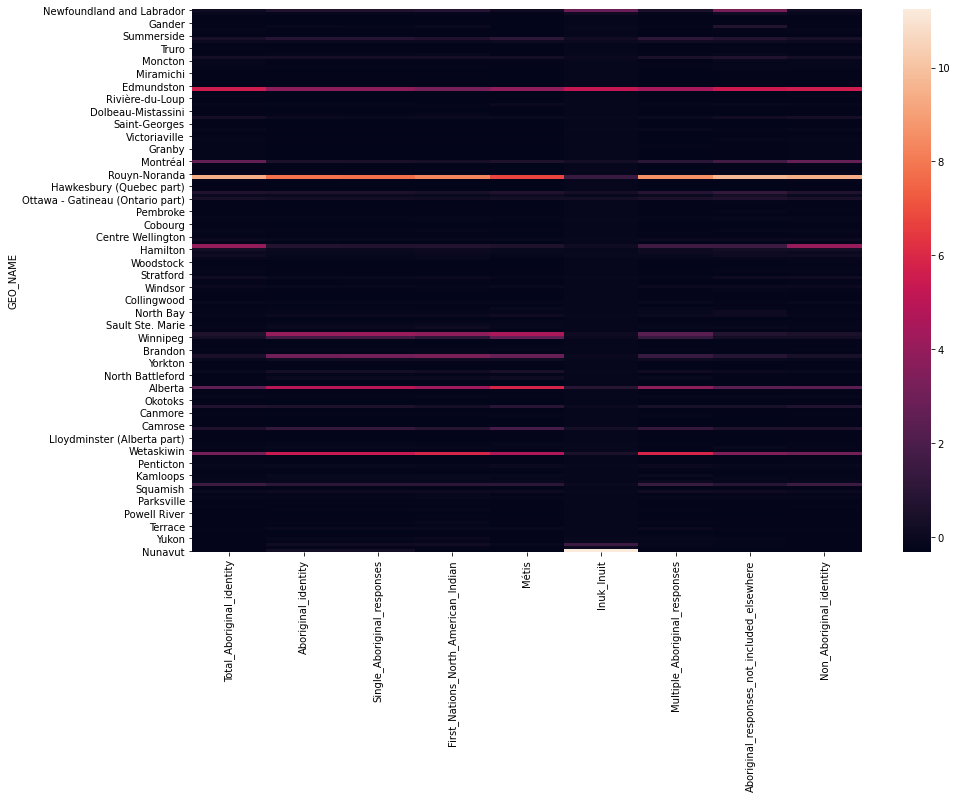

In [0]:
plt.figure(figsize=(15, 10))
sns.heatmap(df)
plt.show()

# 4.	Bonus 2: Using Dataset 1, create an interface/API where users can visualize the population and Average Total Income by selecting the following Dimensions:

This part is done in Tableau and hosted on the public website.

# 5.	Bonus 3: Join Dataset 1 and 2 and create a single dataset that can provide the following metrics by Canadian province

Load dataset 2

In [0]:
dataset2_full = spark.read.format('csv').options(header = 'true', inferSchema = 'true').load('dbfs:/mnt/blobstorage/dataset2/91f38852-5351-4753-bfc6-c4d12aed73f1/98-400-X2016131_English_CSV_data.csv')
dataset2_geo_mapping = spark.read.format('csv').options(header = 'true', inferSchema = 'true').load('dbfs:/mnt/blobstorage/dataset2/91f38852-5351-4753-bfc6-c4d12aed73f1/Geo_starting_row_CSV.csv')

Replace any non alphanumeric character from column name

In [0]:
# The main dataset
for curr_col in dataset2_full.columns:
    dataset2_full = dataset2_full.withColumnRenamed(curr_col, re.sub('[\W_]+', '_', curr_col))
    
# The Geo map dataset
for curr_col in dataset2_geo_mapping.columns:
    dataset2_geo_mapping = dataset2_geo_mapping.withColumnRenamed(curr_col, re.sub('[\W_]+', '_', curr_col))

In [0]:
# This function will union two spark dataframes.
def custom_union(df1, df2):
    # find columns in df1 which are not in df2
    cols1 = []
    for curr_col in df1.columns:
        if curr_col not in df2.columns:
            cols1.append(curr_col)
    
    # find columns in df2 which are not in df1
    cols2 = []
    for curr_col in df2.columns:
        if curr_col not in df1.columns:
            cols2.append(curr_col)
    
    for curr_col in cols2:
        df1 = df1.withColumn(curr_col, F.lit(None))
        
    for curr_col in cols1:
        df2 = df2.withColumn(curr_col, F.lit(None))
        
    return df1.unionByName(df2)

In [0]:
joined_dataset = custom_union(dataset1_full, dataset2_full)

In [0]:
display(joined_dataset)

CENSUS_YEAR,GEO_CODE_POR_,GEO_LEVEL,GEO_NAME,GNR,DATA_QUALITY_FLAG,ALT_GEO_CODE,DIM_Registered_or_Treaty_Indian_status_3_,Member_ID_Registered_or_Treaty_Indian_status_3_,Notes_Registered_or_Treaty_Indian_status_3_,DIM_Age_9_,Member_ID_Age_9_,Notes_Age_9_,DIM_Sex_3_,Member_ID_Sex_3_,Notes_Sex_3_,DIM_Income_statistics_17_,Member_ID_Income_statistics_17_,Notes_Income_statistics_17_,Total_Aboriginal_identity,Aboriginal_identity,Single_Aboriginal_responses,First_Nations_North_American_Indian,Métis,Inuk_Inuit,Multiple_Aboriginal_responses,Aboriginal_responses_not_included_elsewhere,Non_Aboriginal_identity,four_region,DIM_Household_living_arrangements_for_persons_not_in_economic_families_3_,Member_ID_Household_living_arrangements_for_persons_not_in_economic_families_3_,Notes_Household_living_arrangements_for_persons_not_in_economic_families_3_,DIM_Presence_of_earner_3_,Member_ID_Presence_of_earner_3_,Notes_Presence_of_earner_3_,DIM_After_tax_income_groups_18_,Member_ID_After_tax_income_groups_18_,Notes_After_tax_income_groups_18_,Dim_Year_2_Member_ID_1_2015_Note_2_,Dim_Year_2_Member_ID_2_2005_Note_3_
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,Total - Income statistics,1,3,28643020,1224915,1191495,691405,456555,43530,15300,18120,27418100,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,With total income,2,null,27489400,1139125,1107725,634225,432640,40860,14200,17200,26350270,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,Percentage with total income (%),3,null,96,93,93,91,94,93,92,94,96,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,Median total income ($),4,null,34205,25526,25485,21875,31916,24502,24800,28813,34604,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,Average total income ($),5,null,47487,36043,35920,31519,42187,37871,41057,39795,47981,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,With after-tax income,6,null,27500230,1139560,1108150,634480,432815,40860,14200,17210,26360665,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,Percentage with after-tax income (%),7,null,96,93,93,91,94,93,92,95,96,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,Median after-tax income ($),8,null,30861,24277,24252,21253,29068,23635,23518,26393,31144,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,Average after-tax income ($),9,null,38977,31205,31139,28108,35440,32647,33484,33548,39313,null,null,null,null,null,null,null,null,null,null,null,null
2016,1,0,Canada,5.1,20000,1,Total - Population by Registered or Treaty Indian status,1,1,Total - Age,1,null,Total - Sex,1,null,With employment income,10,null,20428670,826460,804260,435045,336830,32385,10170,12030,19602210,null,null,null,null,null,null,null,null,null,null,null,null


This single joined dataset will help us calculate the following metrics as required:
- Population for “Aboriginal Identity”
- Population for “Non-Aboriginal Identity”
- Total population in 2015 in high income group (after-tax income >= $70,000) where an earner is present in the household

# Write the answers and data to an SQL server such that it can later be picked up by others and use for analysis

In [0]:
server = dbutils.secrets.get(scope = 'key-secret-scope', key = 'sqlserver')
database = dbutils.secrets.get(scope = 'key-secret-scope', key = 'sqldatabase')
user = dbutils.secrets.get(scope = 'key-secret-scope', key = 'sqluser')
password = dbutils.secrets.get(scope = 'key-secret-scope', key = 'sqlpassword')


url = 'jdbc:sqlserver://{}:1433;database={};user={};password={};encrypt=true;trustServerCertificate=false;hostNameInCertificate=*.database.windows.net;loginTimeout=30;'.format(server, database, user, password)

In [0]:
spark.conf.set('fs.azure.account.key.{}.blob.core.window.net'.format(storage_account_name), storage_account_key)

In [0]:
# This function will write the spark dataframe to sql database.
def write_to_db(df, tablename):
    (df.write
     .format("jdbc")
     .mode('overwrite')
     .option("url", url)
     .option("dbtable", tablename)
     .option("user", "username")
     .option("password", "password")
     .save()
    )

In [0]:
write_to_db(dataset1_full, 'dataset1')

In [0]:
csv_location = '/mnt/blobstorage/cleanseddata'

In [0]:
def store_spark_df(csv_location, df, name):
    dbutils.fs.rm(csv_location, recurse= True)
    df.repartition(1).write.csv(path = '/mnt/blobstorage/cleanseddata', header = True)

    csv_file_path = ''
    for file in dbutils.fs.ls(csv_location):
        if file.name.endswith('.csv') and file.name.startswith('part-0000'):
            csv_file_path = file.path
            break

    dbutils.fs.cp(csv_file_path, '/mnt/blobstorage/' + name)
    dbutils.fs.rm(csv_location, recurse= True)

In [0]:
store_spark_df(csv_location, dataset1_full, 'dataset1.csv')
store_spark_df(csv_location, answer_a, 'answer_a.csv')
store_spark_df(csv_location, answer_b, 'answer_b.csv')
store_spark_df(csv_location, answer_c, 'answer_c.csv')
store_spark_df(csv_location, answer_d, 'answer_d.csv')

# Unmount the blob storage

In [0]:
dbutils.fs.unmount('/mnt/blobstorage')

/mnt/blobstorage has been unmounted.
Out[160]: True